# Working with text

In this problem, we will load movie reviews from IMDB, a famous movie database and website, and we will try to predict whether the review is positive or negative.

First, the function we will use to diagnose the performance of our model

In [1]:
%pylab inline
plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


In [0]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  

## Input data

In [0]:
from keras.datasets import imdb

In [5]:
# Run this to download the data prior to the lecture
train, test = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 4s 0us/step


In [6]:
#vamos a ver estas dos variables, tenemos tuplas. Por un lado tenemos las textos y por otro las etiquetas
type(train)


tuple

In [0]:
train_text, train_labels=train

In [0]:
test_text, test_labels=test

In [10]:
#vamos a ver 10 palabras del 4º review
train_text[4][0:10]

[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637]

In [0]:
#¿Porqué son nºs? pq keras ya lo interpreta así. Vamos a ver que palabras son. De un texto saca la lista de palabras distintas que hay, les asigna un nº y hace la correspondencia
#Recuperamos las palabras. Hay que recuperar el indice que ha usado keras para hacer la correspondencia.
word_index=imdb.get_word_index()


Why are these *texts* numbers?

These are actually indices in a word index

In [12]:
word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 2s 1us/step


In [0]:
reversed_word_index = dict((value, key) for (key, value) in word_index.items())

In [0]:
def get_text_from_vector(v):
    return ' '.join(reversed_word_index.get(i-3, '?') for i in v)

In [17]:
get_text_from_vector(train_text[4][0:10])

'? worst mistake of my life br br i picked'

In [0]:
#recapitulando, tenemos que, lo primero, transformar el texto en nº, lo siguiente será componer la matriz.
#Cogeremos la lista de enteros (de diferente long) en una matriz donde cada columna tenga el mismo nº de elementos. (verlibreta)

### Prepare data for the network

We need to prepare the data to be an input to the neural network. The input must be a **tensor**. In our case, all vectors should be of the same length. But not all reviews are of the same size, so the vectors will have different sizes. How can we overcome this problem?

* We can zero-pad the vectors, so all of them have the same size, and then combine them in a tensor. We would need to add an *Embedding* layer to learn **word embeddings** (more later)
* Or we can use 1-HOT encoding

In both cases, we will have vectors of size $10^4$ (the maximum number of words). Let's go with the 1-HOT encoding.

In [0]:
#vamos a transformar los vectores en la matriz de entrada:
from keras.preprocessing import text

In [23]:
#tenemos los textos de train, que es un array de 25mil listas de eneteros cada una de una dimension distinta
print(len(train_text[1]))
print(len(train_text[3]))
print(len(train_text[1255]))

189
550
211


In [0]:
#para poner todas las listas con la misma dimension, hay una funcion llamada sequence_to_matrix--> es un tokenizador (se divide el texto en palabras)
#primero instancio el tokenizador
tokenizer=text.Tokenizer(num_words=10000)#le tengo que decir como de anchos quiero que sean los vectores del one hot encoding. Podemos comprobar que la mayoría son de tamaño menores que 1e4ç

In [0]:
train_text_m=tokenizer.sequences_to_matrix(train_text, mode='binary')#modo binario--> que es un  one hot encoding

In [27]:
train_text_m.shape

(25000, 10000)

In [28]:
#comprobamos en el primer review
train_text_m[0][0:25]

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 0.])

In [0]:
#la primera palabra no la tiene, la 4ª tampoco...

In [0]:
#Pero hay un problema, la repeticion de las palabras en un texto, tamben conlleva informaicon. Aqui se está ignorando esto.
#Otra cosa ignorada, es el orden. Tambien se está pasando por alto en este método. (básicamente es una bolsa de palabras).

In [29]:
#Y con las etiquetas? que pasa? las transformamos o no?
train_labels[0:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [0]:
#dimension de la salida=1 --> Positivo o negativo (la valoración).
#¿qué funcion de activación conocemos?--> logistica (nos tiene que dar un unico valor entre 0 y 1)

#Al final, tienen que encajar las dimensiones. SI no es así tenemos un problema.
#En este caso no tendríamos que transformarlas. (labels)

In [0]:
#hacemos lo mismo con el test
test_text_m=tokenizer.sequences_to_matrix(test_text, mode='binary')

**EXERCISE 1**. Can you see any problem with this approach? How would you solve it?

**EXERCISE 2**. Do we need to transform the labels? Why? Or why not?

## Let's build the model

In [0]:
#vamos a construir el modelo. 
from keras import models
from keras import layers

In [0]:
#creamos un primer modelo secuencial
m1hot=models.Sequential()
m1hot.add(layers.Dense(256,activation='relu',input_shape=(10000,)))#256 pq es lo primero que se me ha ocurrido. Esto se trata de probar. La entrada será el nº de columnas (le pasamos review a review), por lo que el input shape es 10000. Y pongo la , porque input shape tiene que ser una tupla.
#tengo que reducir las dimensiones de las capas, rara vez se expande la salida. Tenemos que ir reduciendo
m1hot.add(layers.Dense(128,activation='relu'))
m1hot.add(layers.Dense(64,activation='relu'))
#la capa final, tiene que ser de dimension 1, y la fucion de activacion tiene que ser adecuada en cada caso, en este caso tiene que ofrecer una salida entre 0 y 1. Ya que vams a comparar entre 0 y 1 de las etiquetas.
m1hot.add(layers.Dense(1,activation='sigmoid'))


In [36]:
m1hot.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2560256   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 2,601,473
Trainable params: 2,601,473
Non-trainable params: 0
_________________________________________________________________


In [0]:
#compilamos el modelo
from keras import optimizers
from keras import losses
from keras import metrics

In [0]:
m1hot.compile(
    optimizer=optimizers.rmsprop(),
    loss=losses.binary_crossentropy,#pq solo hay 2 categorías (0 y 1)
    metrics=[metrics.binary_accuracy]
)

In [39]:
#ajustamos el modelo, guardando su salida para poder comparar
h=m1hot.fit(train_text_m,train_labels,epochs=20,batch_size=1024,validation_split=.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 142us/step - loss: 0.5741 - binary_accuracy: 0.7293 - val_loss: 0.4608 - val_binary_accuracy: 0.7776
Epoch 2/20
20000/20000 [==============================] - 2s 88us/step - loss: 0.3128 - binary_accuracy: 0.8744 - val_loss: 0.3061 - val_binary_accuracy: 0.8754
Epoch 3/20
20000/20000 [==============================] - 2s 88us/step - loss: 0.2222 - binary_accuracy: 0.9104 - val_loss: 0.2829 - val_binary_accuracy: 0.8900
Epoch 4/20
20000/20000 [==============================] - 2s 90us/step - loss: 0.1780 - binary_accuracy: 0.9305 - val_loss: 0.2697 - val_binary_accuracy: 0.8928
Epoch 5/20
20000/20000 [==============================] - 2s 87us/step - loss: 0.1251 - binary_accuracy: 0.9541 - val_loss: 0.3228 - val_binary_accuracy: 0.8896
Epoch 6/20
20000/20000 [==============================] - 2s 97us/step - loss: 0.1181 - binary_accuracy: 0.9600 - val_loss: 0.3135 - val_binary_a

# Analyze performance

In [0]:
#vamos a ver los valores que salen.

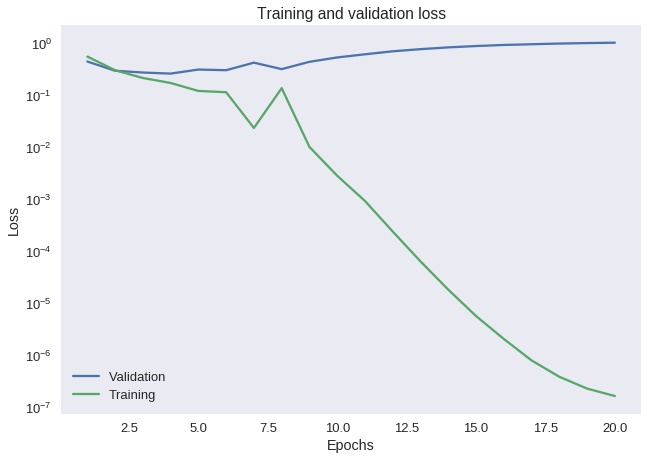

In [43]:
plot_metric(h, 'loss')

In [0]:
#el training lo clavo pero pero mira la validacion, es overfitting

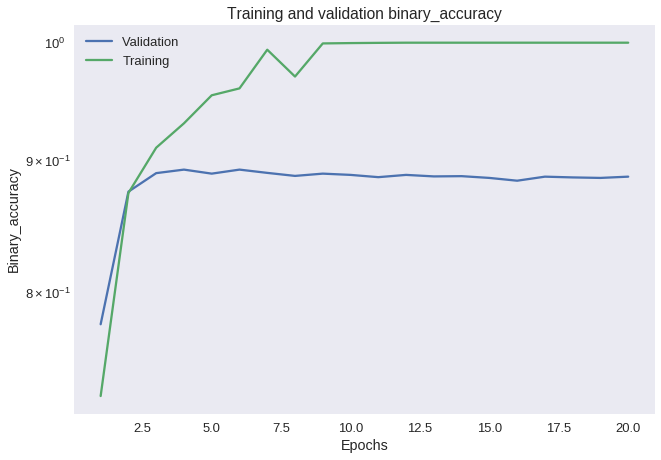

In [41]:
plot_metric(h, 'binary_accuracy')

In [45]:
#esta aproximación es muy pobre, por ello tenemos que usar otra forma de formar la matriz-->word embeddings
m1hot.evaluate(test_text_m,test_labels)
#viendo esto no está tan mal, pero claro, como hemos visto antes hay overfitting y no es la mejor solucion.

25000/25000 [==============================] - 3s 139us/step


[1.1608314690730326, 0.8742]

We cannot find a satisfactory model with what we have learned so far. Is there any way to have a better representation of text that can provide better results?

# Word embeddings

Using 1-HOT encoded vectors produce large and sparse tensors, that are difficult to learn from using a neural network. Word embeddings are compact vectors, representing words in a vector space. These vectors are learnt in a neural network, with a layer of type *Embedding*. We can also even use pre-trained word embeddings, to improve our model

![](./imgs/07_embeddings.png)

To generate  an embedding, we need to tokenize the text, transforming words into indices, and then we use these lists of numbers to produce the vectorial representation:

![](./imgs/08_embeddings.png)

More info:
* http://www.offconvex.org/2015/12/12/word-embeddings-1/
* http://www.offconvex.org/2016/02/14/word-embeddings-2/

## Input data for word embeddings

In [0]:
#los datos de entrada son los mismos de antes:secuencia de listas de enteros y etiquetas.
# Haremos lo que es el PADDIN: decidir tamaño maximo delos reviews, se truncarán los que sean mas largos y los que sean mas cortos se cubrirán con ceros (tendrá alguna influencia)


In [0]:
max_len=100
embedding_dim=32#dimensiones del embeding
max_words=10000

In [0]:
#hacemos el padding de la secuencia para obtener el texto padeado.
from keras.preprocessing import sequence
#ahora vamos a importar el texto como una secuencia, lo que conservará el orden de las palabras

In [0]:
train_text_p=sequence.pad_sequences(train_text,maxlen=max_len)
test_text_p=sequence.pad_sequences(test_text,maxlen=max_len)

In [50]:
#esto es todo lo que tenemos que hacer para obtener embedings de estos datos. Vamos a ver:
train_text_p.shape
#se acotan los textos a 100 palabras (truncamos y/o rellenamos con 0s) cada palabra se mapeará a un vector de dim 32. Si se repite la palabra, aparecerá el vector 2 veces. De alguna manera los vectores se ordenará en el espacio para capturar las relaciones

(25000, 100)

## Let's build the model with embeddings

In [0]:
#nosotros o entrenamos el embedding o cogemos otro preentrenado. (ver GLOVE (pre_training word embebed vectors (espacio vectorial)), entrenado con textos de wikipedia)

m2emb=models.Sequential()
m2emb.add(layers.Embedding(max_len,embedding_dim))#ahora las capas son de tipo embeding, no hay funcion de activacion pq quiero aprovechar toda la info del espacio vectorial. El imput shape no es el normal (tiene que aceptar a la entrada vectores de 100) y la salida tiene que se la dimension del embedding
m2emb.add(layers.Dense(32,activation='relu'))#añadimos una capa densa
m2emb.add(layers.Dense(16,activation='relu'))#añadimos una capa densa
m2emb.add(layers.Dense(1,activation='sigmoid'))


In [0]:
m2emb.compile(
    optimizer=optimizers.rmsprop(),
    loss=losses.binary_crossentropy,#pq solo hay 2 categorías (0 y 1)
    metrics=[metrics.binary_accuracy]
)

In [57]:
m2emb.summary()#ahora hay menos parametros pq el modelo es menor

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          3200      
_________________________________________________________________
dense_5 (Dense)              (None, None, 32)          1056      
_________________________________________________________________
dense_6 (Dense)              (None, None, 16)          528       
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           17        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [58]:
h=m2emb.fit(train_text_p,train_labels,epochs=20,batch_size=1024,validation_split=.2)

ValueError: ignored

In [0]:
#vemos q falla pq la ultima capa tiene un output shape de dimension 3. hab´ra que veer que le pasa... el profesor lo deja ahí, no teiene gana de pensar.

In [0]:
#OTRO TIPO de capas: REDES RECURRENTES. Son capaces de modelar la secuencia de elementos (tienen memoria corta)
m2emb=models.Sequential()
m2emb.add(layers.Embedding(max_len,embedding_dim))#ahora las capas son de tipo embeding, no hay funcion de activacion pq quiero aprovechar toda la info del espacio vectorial. El imput shape no es el normal (tiene que aceptar a la entrada vectores de 100) y la salida tiene que se la dimension del embedding
m2emb.add(layers.SimpleRNN(32))#añadimos una capa redes neuronales recurrenttes
m2emb.add(layers.Dense(1,activation='sigmoid'))

#vamos a entrenarlo solo con una capa recurrente

In [60]:
m2emb.summary()#ahora hay menos parametros pq el modelo es menor

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          3200      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 5,313
Trainable params: 5,313
Non-trainable params: 0
_________________________________________________________________


In [0]:
m2emb.compile(
    optimizer=optimizers.rmsprop(),
    loss=losses.binary_crossentropy,#pq solo hay 2 categorías (0 y 1)
    metrics=[metrics.binary_accuracy]
)

In [62]:
h=m2emb.fit(train_text_p,train_labels,epochs=20,batch_size=1024,validation_split=.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 86us/step - loss: 0.6888 - binary_accuracy: 0.5453 - val_loss: 0.6779 - val_binary_accuracy: 0.5650
Epoch 2/20
20000/20000 [==============================] - 1s 74us/step - loss: 0.7334 - binary_accuracy: 0.5086 - val_loss: 0.7249 - val_binary_accuracy: 0.5052
Epoch 3/20
20000/20000 [==============================] - 1s 75us/step - loss: 0.7099 - binary_accuracy: 0.5122 - val_loss: 0.7131 - val_binary_accuracy: 0.5086
Epoch 4/20
20000/20000 [==============================] - 1s 74us/step - loss: 0.7373 - binary_accuracy: 0.5107 - val_loss: 0.7613 - val_binary_accuracy: 0.5222
Epoch 5/20
20000/20000 [==============================] - 2s 83us/step - loss: 0.7833 - binary_accuracy: 0.4960 - val_loss: 0.7616 - val_binary_accuracy: 0.5066
Epoch 6/20
20000/20000 [==============================] - 1s 74us/step - loss: 0.7367 - binary_accuracy: 0.5068 - val_loss: 0.7215 - val_binary_ac

In [0]:
#ya a acabado de entrenar, vemos a ver que tal se ha comportado

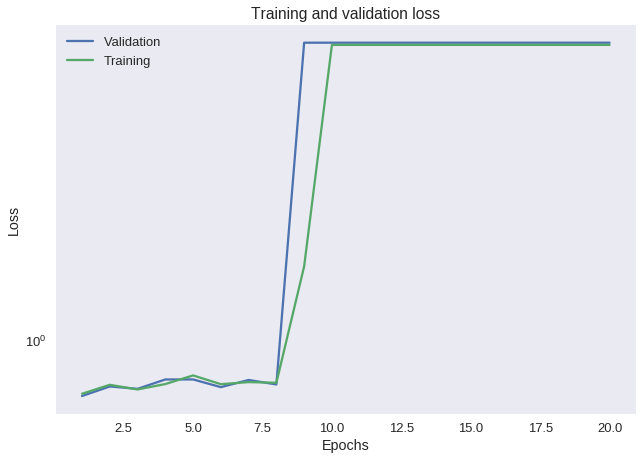

In [64]:
plot_metric(h,'loss')
#esto es muy raro, pq tendría que decrecer y el accuracy baja

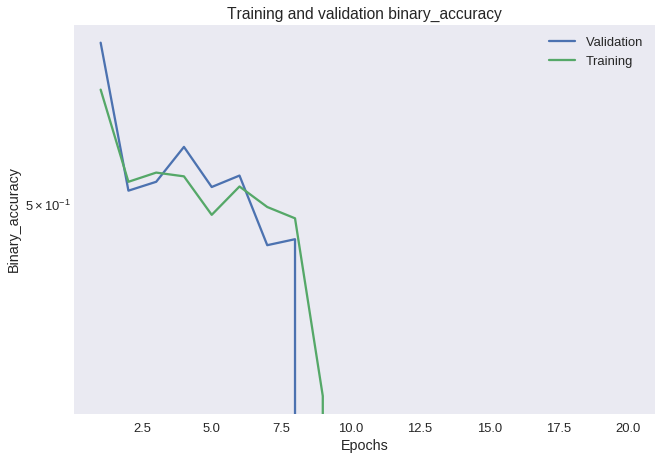

In [69]:
plot_metric(h,'binary_accuracy')

In [0]:
#vamos a añadir otras capa recurrente, para probar
m2emb=models.Sequential()
m2emb.add(layers.Embedding(max_len,embedding_dim))#ahora las capas son de tipo embeding, no hay funcion de activacion pq quiero aprovechar toda la info del espacio vectorial. El imput shape no es el normal (tiene que aceptar a la entrada vectores de 100) y la salida tiene que se la dimension del embedding
m2emb.add(layers.SimpleRNN(32,return_sequences=True))#añadimos una capa redes neuronales recurrenttes, para poder concatenar capas RNN la capa anterior RNN tiene que devolver una secuencia
m2emb.add(layers.SimpleRNN(16,return_sequences=True))#añadimos una capa redes neuronales recurrenttes
m2emb.add(layers.SimpleRNN(8))#añadimos una capa redes neuronales recurrenttes
m2emb.add(layers.Dense(1,activation='sigmoid'))

In [72]:
m2emb.summary()#tiene pinta de que va a ir bien

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          3200      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 16)          784       
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 6,273
Trainable params: 6,273
Non-trainable params: 0
_________________________________________________________________


In [0]:
m2emb.compile(
    optimizer=optimizers.rmsprop(),
    loss=losses.binary_crossentropy,#pq solo hay 2 categorías (0 y 1)
    metrics=[metrics.binary_accuracy]
)

In [74]:
h=m2emb.fit(train_text_p,train_labels,epochs=20,batch_size=1024,validation_split=.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 5s 226us/step - loss: 0.7173 - binary_accuracy: 0.5217 - val_loss: 0.7016 - val_binary_accuracy: 0.5350
Epoch 2/20
20000/20000 [==============================] - 4s 199us/step - loss: 0.6959 - binary_accuracy: 0.5367 - val_loss: 0.6935 - val_binary_accuracy: 0.5384
Epoch 3/20
20000/20000 [==============================] - 4s 198us/step - loss: 7.5742 - binary_accuracy: 0.0283 - val_loss: 8.0700 - val_binary_accuracy: 0.0000e+00
Epoch 4/20
20000/20000 [==============================] - 4s 198us/step - loss: 7.9465 - binary_accuracy: 0.0000e+00 - val_loss: 8.0700 - val_binary_accuracy: 0.0000e+00
Epoch 5/20
20000/20000 [==============================] - 4s 199us/step - loss: 7.9465 - binary_accuracy: 0.0000e+00 - val_loss: 8.0700 - val_binary_accuracy: 0.0000e+00
Epoch 6/20
20000/20000 [==============================] - 4s 197us/step - loss: 7.9465 - binary_accuracy: 0.0000e+00 - va

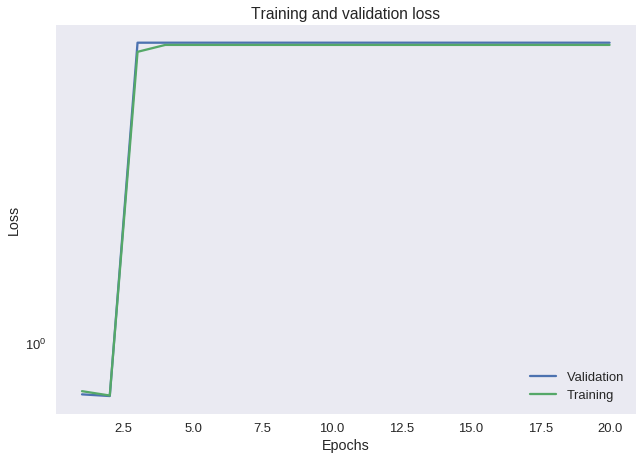

In [75]:
plot_metric(h,'loss')

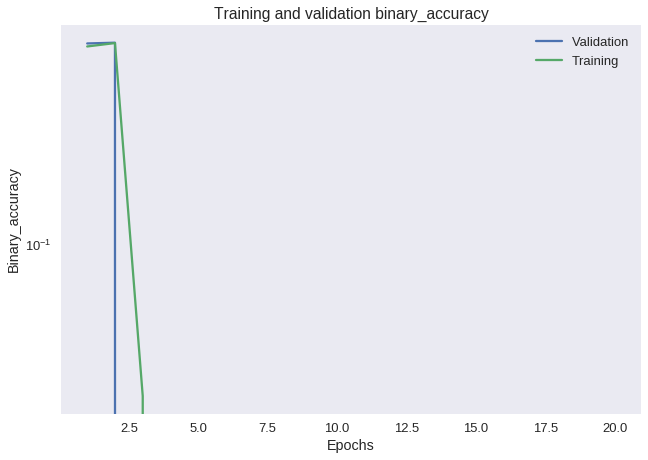

In [76]:
plot_metric(h,'binary_accuracy')

In [0]:
#abandono estos modelos, no se obtienen buenos resultados. Sale igual que antes. Vamos a descartarlos pq en realidad RNN no se usa, hay otro tipo de capas particular que se ha demostrado que funcionan muy bien en otros ambitos por ejemplo imágenes
#Se trata de las capas LSTM, son recurrentes con memoria.

In [0]:
m2emb=models.Sequential()
#!!! DABA ERROR PQ HAY QUE PONER MAX_WORD NO MAX_LEN, eso era lo que pasaba
m2emb.add(layers.Embedding(max_words,embedding_dim))#ahora las capas son de tipo embeding, no hay funcion de activacion pq quiero aprovechar toda la info del espacio vectorial. El imput shape no es el normal (tiene que aceptar a la entrada vectores de 100) y la salida tiene que se la dimension del embedding
m2emb.add(layers.LSTM(32,return_sequences=True))#añadimos una capa redes neuronales recurrenttes LSTM
m2emb.add(layers.LSTM(16))#añadimos una capa redes neuronales recurrenttes LSTM
m2emb.add(layers.Dense(1,activation='sigmoid'))

In [88]:
m2emb.summary()#es un modelo mucho mas complejo

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 331,473
Trainable params: 331,473
Non-trainable params: 0
_________________________________________________________________


In [0]:
m2emb.compile(
    optimizer=optimizers.rmsprop(),
    loss=losses.binary_crossentropy,#pq solo hay 2 categorías (0 y 1)
    metrics=[metrics.binary_accuracy]
)

In [90]:
h=m2emb.fit(train_text_p,train_labels,epochs=10,batch_size=1024,validation_split=.2)#nos va a quedar un modelo undefitting con 10 epocas, pero es que no se puede

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 13s 629us/step - loss: 0.6365 - binary_accuracy: 0.6462 - val_loss: 0.4734 - val_binary_accuracy: 0.7826
Epoch 2/10
20000/20000 [==============================] - 11s 545us/step - loss: 0.4308 - binary_accuracy: 0.8095 - val_loss: 0.4717 - val_binary_accuracy: 0.7816
Epoch 3/10
20000/20000 [==============================] - 11s 539us/step - loss: 0.3573 - binary_accuracy: 0.8513 - val_loss: 0.3915 - val_binary_accuracy: 0.8310
Epoch 4/10
20000/20000 [==============================] - 11s 544us/step - loss: 0.3065 - binary_accuracy: 0.8791 - val_loss: 0.3966 - val_binary_accuracy: 0.8258
Epoch 5/10
20000/20000 [==============================] - 11s 541us/step - loss: 0.2746 - binary_accuracy: 0.8946 - val_loss: 0.3972 - val_binary_accuracy: 0.8290
Epoch 6/10
20000/20000 [==============================] - 11s 545us/step - loss: 0.2507 - binary_accuracy: 0.9023 - val_loss: 0.4652 - v

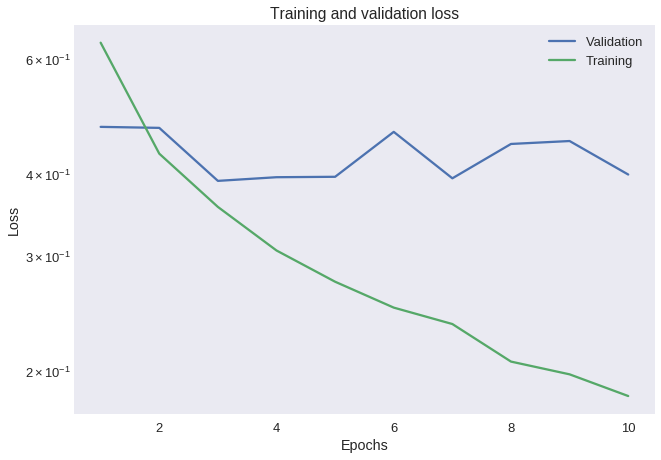

In [91]:
plot_metric(h,'loss')
#lo que sale es normal

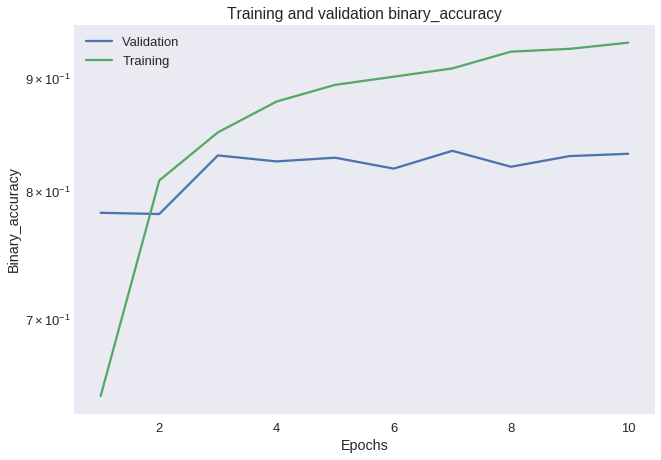

In [92]:
plot_metric(h,'binary_accuracy')
#Esto es una cosa más normal

In [94]:
m2emb.evaluate(test_text_p,test_labels, batch_size=1024)
#vamos que ya sale bien, un 82%

25000/25000 [==============================] - 3s 127us/step


[0.41304556752204896, 0.8282399998664856]

## Analyze performance

Not bad, with just an embedding layer, we get $75\%$ accuracy

In [95]:
loss,acc=m2emb.evaluate(test_text_p,test_labels, batch_size=1024)

25000/25000 [==============================] - 3s 117us/step


In [96]:
acc


0.8282399998664856

How many reviews will be misclassified?

In [97]:
(1-acc)*test_text.shape[0]

4294.000003337861

Let's check some of the predictions

In [0]:
N = 123
# N = 2344

In [99]:
m2emb.predict(test_text_p[N:N+1])[0][0]

0.97881776

In [101]:
test_labels[N]

1

So this prediction is correct. It says the review is negative. Let's have a look at the text:

In [102]:
get_text_from_vector(test_text[N])

"? if you believe that any given war movie can make you really feel the war you need to see called the ? are flying in english it tells the story of ? ? and boris who are in love on the verge of wwii they are walking along the ? watching the ? fly by when the war starts boris is promptly sent off to war ? hides out with a family and ends up marrying the son whom she does not love boris meanwhile continues ? through the countryside fighting the nazis and experiencing all the horrors of war until he he runs out of energy when ? working in a military hospital receives this news she refuses to accept it until ? body arrives home on one of the trains simultaneously the radio ? that germany has ? and the allied powers have won the war the soviet union lost 27 million citizens but it's the start of a new era br br this movie did a very good job showing the human impact of the war not only in the battlefield but also how it affected the ? population this is definitely a movie that everyone sho

In [103]:
N = 2344
m2emb.predict(test_text_p[N:N+1])[0][0]

0.033810757

In [104]:
test_labels[N]

0

In [105]:
get_text_from_vector(test_text[N])

"? there is a reason ? of the board got a 2 which is too high this movie flat out is one of the worse movies of all time and i seen my share of rotten films ? of the board stars two of the most annoying actors people today ? top and ? ? smith ? top just isn't funny anymore and wasn't in this piece of trash ? ? smith isn't any better just watch according to jim and you will see a prime example of what i am talking about ? of the board got a 1 from me because that is low as you can go it is that bad i am a little shocked that this piece of junk isn't on the imdb bottom 100 somewhere i would put this in the top 5 on that list but its slowly working its way there"

Can we find all the reviews that are wrongly classified?

In [0]:
get_text_from_vector(test_text[3])

"? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are ? involved with the actions on the screen so then why the hell can't we have night vision"

Is the classifier symmetric?

In [0]:
#tenemos que comprobar esto

**EXERCISE** Can you construct the confusion matrix for this model? Can you calculate the precision and recall? How does it compare to accuracy?
* See https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

**EXERCISE (more complex)** Keras decided some time ago to remove precision, recall and F1-score from the list of available metrics. Was it a good decision? Why? Why did the Keras' authors did not remove accuracy too?
* https://github.com/keras-team/keras/issues/5794
* https://github.com/keras-team/keras/issues/4592

**EXERCISE** What is the ROC curve? Could you build the ROC curve for this model? How would you use a ROC curve to evaluate a classifier?
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic
* Help: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [0]:
#sacamos la curva ROC para comparar estos ultimos modelos

In [0]:
from sklearn import metrics

In [0]:
#Para hace una curva ROC, necesito el vector de las predcciones (valores reales) y el vector de enteros. En cada punto de la curva roc se calculan los falsos positivos y los verdaderos positivos.


In [0]:
pred1=m1hot.predict(test_text_m)
pred2=m2emb.predict(test_text_p)

In [0]:
curva1=metrics.roc_curve(test_labels,pred1)
curva2=metrics.roc_curve(test_labels,pred2)

In [111]:
#curva1 y curva2 son tuplas de 3 elementos. 
curva1[2].shape
#sklearn ha decidifo poner 3859 puntos para dibujar una curva

(3859,)

In [0]:
#deshaciendo tuplas
fpr1,tpr1,_=curva1
fpr2,tpr2,_=curva2

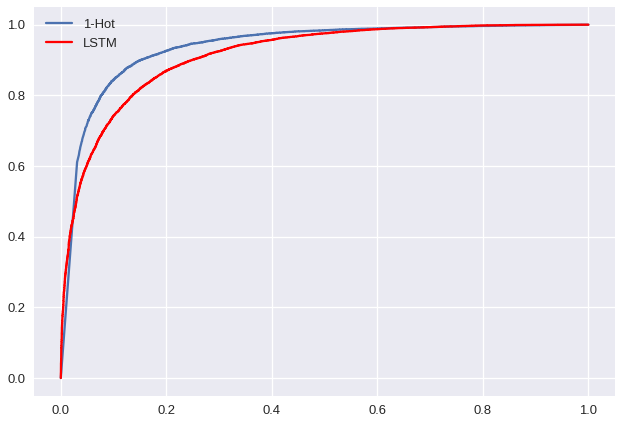

In [115]:
#dibujamos
plt.plot(fpr1,tpr1,label='1-Hot')
plt.plot(fpr2,tpr2,'red',label='LSTM')
plt.legend()

In [0]:
# en este caso, sale mejor 1-HOT. Hay menos capas y menos épocas en el LSTM, por lo que es una comparacion un poco injusta.
#En la zona baja, si pusieramos un valor umbral bajo, el rojo se comporta mejor que el azul (más área bajo la curva). Pero en términos generales la azul es mejor.
#La ROC no pone umbral, ahí radica lo que nosotros decidamos. Tras vicualizar la curva es cuando tenemos que decir que modelo es mejor que el otro según queramos nosotros (ahí estamos estableciendo el umbral).

#las situaciones donde en la zona baja es mejor uno y en la alta es peor, son situaciones asimétricas.

Let's analyze wrong positives and wrong negatives separately. Then we will try to find a relationship between the words and the misclassification, both for false positives and negatives.

Now let's compare with the words of the true positives

So the most common words are very similar. Not surprising. Let's calculate the relative frequency of each word, and then find what are the words with the highest difference in relative frequency.

We see words such as *great*, *best*, *excellent*, which have a large difference between the true and the false positives. So false positives seem to lack some extreme words, and the classifier is having a hard time trying to assign a category to those reviews.